## ***Initial Setup***

In [0]:
import os
import shutil
from pathlib import Path

In [0]:
DATA_DIR = Path('data/ships')
MODEL_DIR = Path('model/ships')

In [0]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

FIRST_RUN = not os.path.exists(str(MODEL_DIR))

In [0]:
if not IN_COLAB:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
if FIRST_RUN:
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if IN_COLAB and FIRST_RUN:
    !pip install -q -U toai
    !pip install -q  --no-deps tensorflow-addons~=0.6

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if IN_COLAB and FIRST_RUN:
    setup_kaggle()

In [0]:
import kaggle

if IN_COLAB and FIRST_RUN:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset='arpitjain007/game-of-deep-learning-ship-datasets',
        path=DATA_DIR,
        unzip=True,
    )
    shutil.unpack_archive(filename=str(DATA_DIR/'train.zip'), extract_dir=DATA_DIR)

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer, split_df
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import (
    ImageLearner,
    ImageAugmentor,
    ImageDataset,
    ImageParser,
    ImageResizer,
    LearningRateFinder,
    ImageTrainingCycle,
    ImageTrainer,
)
from toai.utils import download_file, unzip, save_file, load_file
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from typing import *

In [0]:
print('TensorFlow ver.', tf.__version__)
print('TOAI ver.', __import__('toai').__version__)

TensorFlow ver. 2.0.0
TOAI ver. 0.1.30


In [0]:
if FIRST_RUN:
    exit()

In [0]:
%matplotlib inline

## ***Dataset Description***

In [0]:
raw_df = pd.read_csv(DATA_DIR/'train.csv', low_memory=True)

In [0]:
folder = str(DATA_DIR/'images')
raw_df['path'] = folder + '/' + raw_df['image']

category_map = {'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}
raw_df['label'] = raw_df['category'].map({value: key for key, value in category_map.items()})

raw_df.head()

,image,category,path,label
0,2823080.jpg,1,data/ships/images/2823080.jpg,Cargo
1,2870024.jpg,1,data/ships/images/2870024.jpg,Cargo
2,2662125.jpg,2,data/ships/images/2662125.jpg,Military
3,2900420.jpg,3,data/ships/images/2900420.jpg,Carrier
4,2804883.jpg,2,data/ships/images/2804883.jpg,Military


In [0]:
image_col = 'path'
target_col = 'label'

In [0]:
df_dims = raw_df.shape
print(f'Total number of images in training dataset is {df_dims[0]}.')

n_classes = raw_df[target_col].nunique()
print(f'Total number of classes is {n_classes}.')

Total number of images in training dataset is 6252.
Total number of classes is 5.


In [0]:
class_dist_df = raw_df[[image_col, target_col]].groupby(target_col, as_index=False).count()

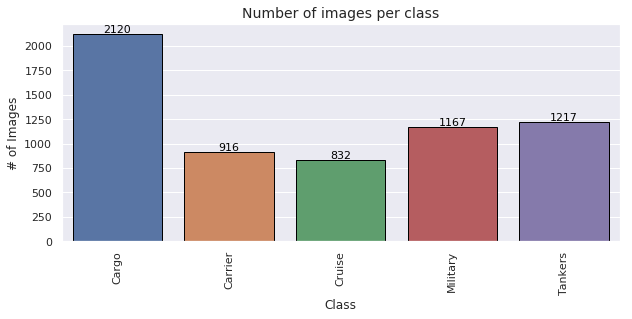

In [0]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(10, 4))

# rendering plot
sns.barplot(x='label', y='path', data=class_dist_df, edgecolor='black')

# adding chart title
plt.title('Number of images per class', size=14)

# adding custom labels for axes
plt.xlabel("Class")
plt.ylabel("# of Images")

# rotating axis labels
plt.xticks(rotation=90)

# adding labels on data points
for index, row in class_dist_df.iterrows():
    plt.text(row.name, row.path + 15, row.path, color='black', ha="center", size=11)

## ***Data Preparation***

In [0]:
# removing rows from oversampled category
oversample_df = raw_df[raw_df['label'] == 'Cargo']
_, delete_df = train_test_split(oversample_df, test_size=0.4)
sample_df = raw_df.drop(delete_df.index)

In [0]:
IMG_DIMS = (299, 299, 3)

In [0]:
train_data, valid_data, test_data = ImageDataset.split(
    dataset=ImageDataset.from_dataframe(sample_df, image_col, target_col), fracs=(0.8, 0.1, 0.1)
)

In [0]:
train_image_dataset = (
    train_data.dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=True)
    .make_pipeline(
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3, flips="horizontal"),
        ]
    )
    .preprocess()
)

In [0]:
train_image_dataset.label_map

{'Cargo': 0, 'Carrier': 1, 'Cruise': 2, 'Military': 3, 'Tankers': 4}

In [0]:
valid_image_dataset = (
    valid_data.dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=False)
    .make_pipeline(
        label_map=train_image_dataset.label_map,
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
    )
    .save_pipeline(MODEL_DIR/"pred")
    .preprocess()
)

In [0]:
test_image_dataset = (
    test_data.dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=False)
    .load_pipeline(MODEL_DIR/"pred")
    .preprocess()
)

In [0]:
data_container = DataContainer(
    train=train_image_dataset, validation=valid_image_dataset, test=test_image_dataset
)

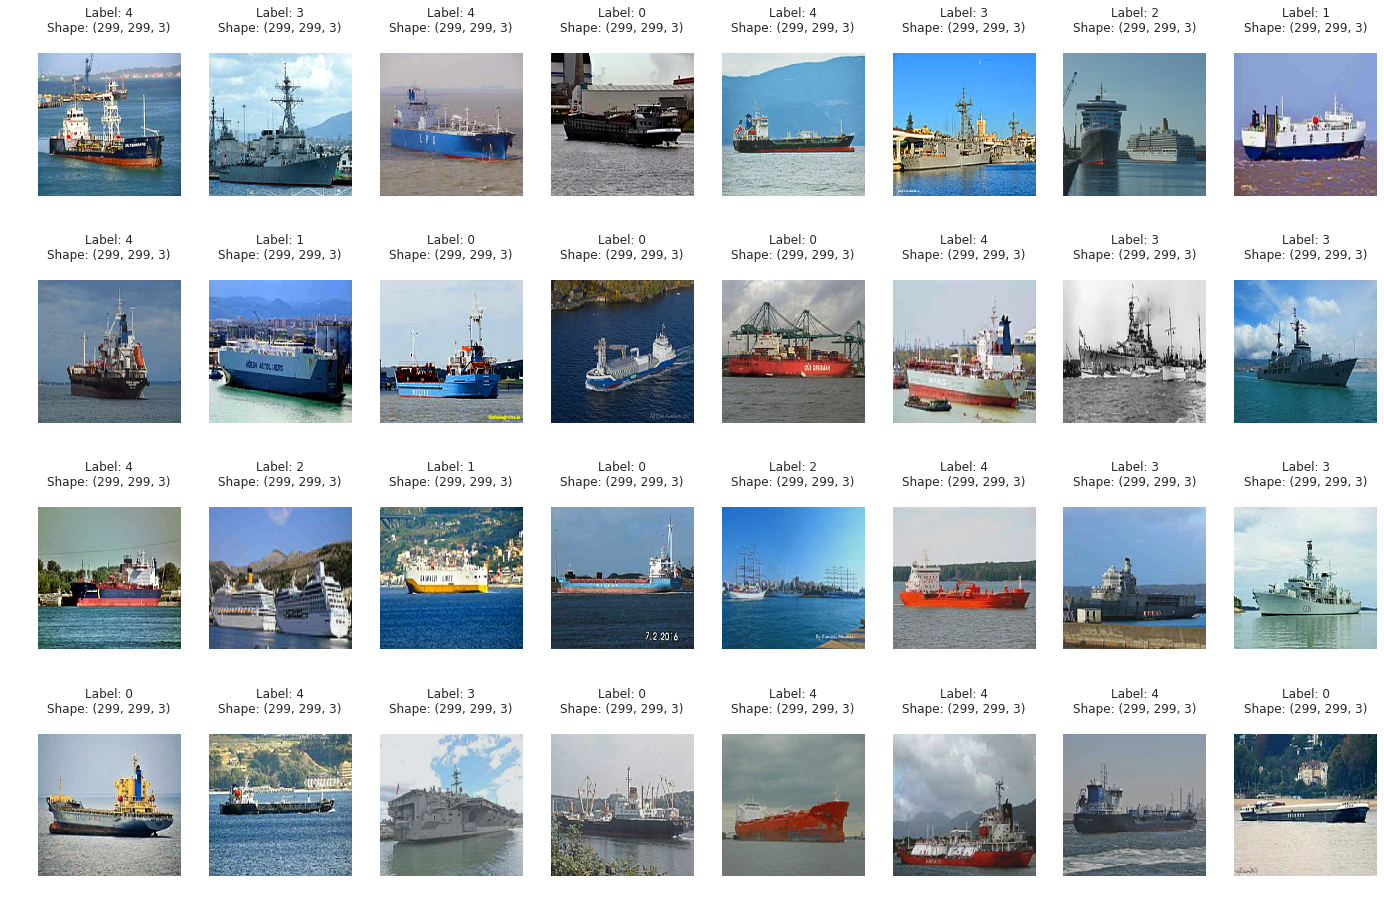

In [0]:
data_container.train.show(debug=True)

## ***Image Classification Model***

In [0]:
learner = ImageLearner(
    path=MODEL_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
    override=True,
)

83689472/83683744 [==============================] - 6s 0us/step


In [0]:
trainer = ImageTrainer(learner=learner, data_container=data_container)

In [0]:
cycles = [
    ImageTrainingCycle(
        n_epochs=5,
        lr=3e-4,
        optimizer=keras.optimizers.Adam,
        freeze=True,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=15,
        lr=1e-4,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=5, flips="horizontal"),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=15,
        lr=3e-5,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3, flips="horizontal"),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=3,
        lr=1e-5,
        optimizer=keras.optimizers.SGD,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3),
        ],
    ),
]

In [0]:
trainer.train(cycles=cycles)

Train for 136 steps, validate for 17 steps
Epoch 1/5
136/136 [==============================] - 148s 1s/step - loss: 1.7573 - sparse_categorical_accuracy: 0.4377 - sparse_top_2_categorical_accuracy: 0.6583 - val_loss: 0.9956 - val_sparse_categorical_accuracy: 0.5460 - val_sparse_top_2_categorical_accuracy: 0.8805
Epoch 2/5
136/136 [==============================] - 112s 827ms/step - loss: 1.0765 - sparse_categorical_accuracy: 0.6372 - sparse_top_2_categorical_accuracy: 0.8267 - val_loss: 0.9871 - val_sparse_categorical_accuracy: 0.5735 - val_sparse_top_2_categorical_accuracy: 0.8897
Epoch 3/5
136/136 [==============================] - 111s 820ms/step - loss: 0.9339 - sparse_categorical_accuracy: 0.6852 - sparse_top_2_categorical_accuracy: 0.8589 - val_loss: 0.8533 - val_sparse_categorical_accuracy: 0.6544 - val_sparse_top_2_categorical_accuracy: 0.9210
Epoch 4/5
136/136 [==============================] - 109s 800ms/step - loss: 0.8359 - sparse_categorical_accuracy: 0.7135 - sparse_top_

In [0]:
trainer.evaluate_dataset()

17/17 [==============================] - 9s 552ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.9596 - sparse_top_2_categorical_accuracy: 0.9890


[0.16565887872403598, 0.95955884, 0.9889706]

In [0]:
preds_df = trainer.analyse_dataset()

In [0]:
print(classification_report(preds_df['label_code'].values, preds_df['pred_code'].values))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       125
           1       0.99      0.99      0.99        95
           2       0.97      0.99      0.98        72
           3       0.96      0.98      0.97       121
           4       0.95      0.93      0.94       128

    accuracy                           0.96       541
   macro avg       0.96      0.96      0.96       541
weighted avg       0.96      0.96      0.96       541



In [0]:
print(confusion_matrix(preds_df['label_code'].values, preds_df['pred_code'].values))

[[116   0   0   4   5]
 [  0  94   0   1   0]
 [  0   0  71   0   1]
 [  1   0   1 119   0]
 [  7   1   1   0 119]]


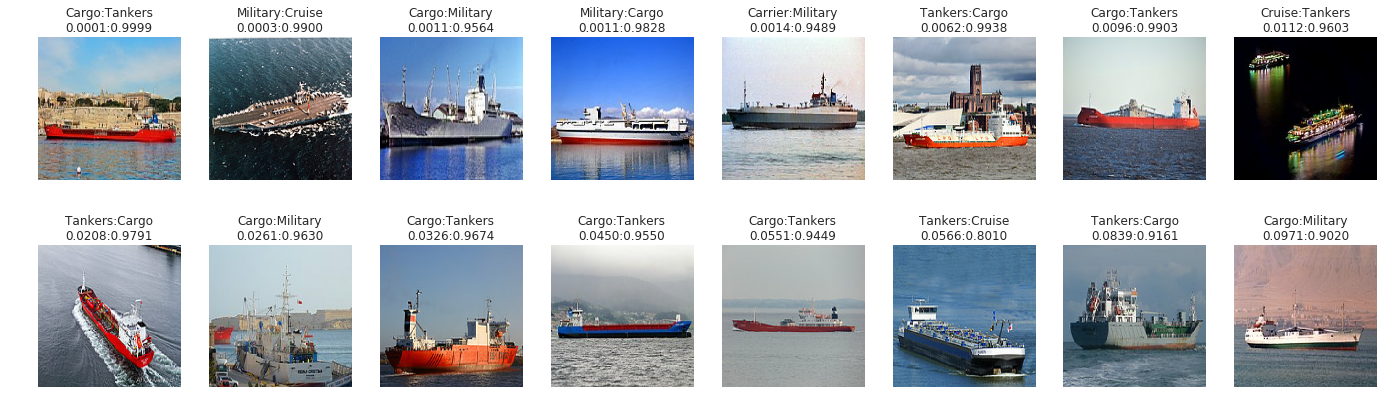

In [0]:
trainer.show_predictions()

In [0]:
initial = ImageLearner(
    path=MODEL_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
initial.load()

In [0]:
initial.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## ***Inverse Image Search***

In [0]:
simple_inverse = ImageLearner(
    path=MODEL_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
simple_inverse.load()

In [0]:
simple_inverse.model = keras.Model(
    inputs=simple_inverse.base_model.input,
    outputs=simple_inverse.concat_layer
)

In [0]:
simple_inverse.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
def show_distances(
    dataset,
    target_index,
    similar_indices,
    distances,
    cols: int = 4,
    debug: bool = False,
):
    if cols >= len(distances) + 1:
        cols = len(distances) + 1
        rows = 1
    else:
        rows = math.ceil((len(distances) + 1) / cols)

    figsize = (3 * cols, 4 * rows) if debug else (3 * cols, 3 * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)

    i = 0
    for x, y, distance in zip(
        dataset.x[[target_index] + similar_indices],
        dataset.y[[target_index] + similar_indices],
        [0] + distances,
    ):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(Image.open(x))
        title = f"Label: {y}\nShape: {x.shape}\n" if debug else f"{y}\n{distance:.2f}"
        ax[idx].set_title(title)
        i += 1

In [0]:
image_embeddings = simple_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x,
)

In [0]:
neighbors = sk.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(image_embeddings)

In [0]:
new_image_index = np.random.randint(len(data_container.train))
new_image_index

1347

In [0]:
new_image_embeddings = simple_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x[new_image_index : new_image_index + 1],
)

In [0]:
distances, indices = neighbors.kneighbors(new_image_embeddings, n_neighbors=11)

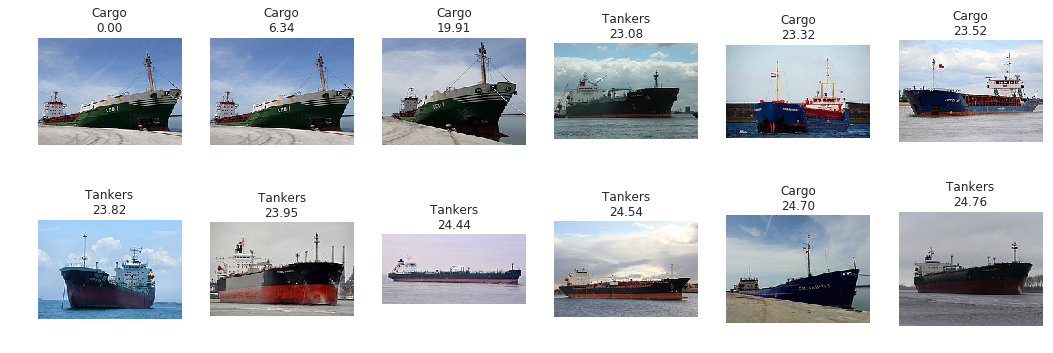

In [0]:
show_distances(data_container.train, new_image_index, indices[0].tolist(), distances[0].tolist(), cols=6)

## ***Inverse Image Search with Squeeze Layer***

In [0]:
squeeze_inverse = ImageLearner(
    path=MODEL_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
squeeze_inverse.load()

In [0]:
squeeze_inverse.squeeze_layer = keras.layers.Dense(
    25,
    activation=keras.activations.relu,
    kernel_initializer=keras.initializers.he_uniform(),
)
squeeze_inverse.output_layer = keras.layers.Dense(
    n_classes,
    activation=keras.activations.softmax,
)

In [0]:
squeeze_inverse.model = keras.Model(
    inputs=squeeze_inverse.base_model.input,
    outputs=squeeze_inverse.output_layer(squeeze_inverse.squeeze_layer(squeeze_inverse.dropout_layer)),
)

In [0]:
squeeze_inverse.model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
squeeze_inverse.compile(optimizer=tf.keras.optimizers.Adam, lr=1e-4)

In [0]:
history = squeeze_inverse.fit(
    train_dataset=data_container.train,
    validation_dataset=data_container.validation,
    epochs=3,
)

Train for 136 steps, validate for 17 steps
Epoch 1/3
136/136 [==============================] - 374s 3s/step - loss: 0.7698 - sparse_categorical_accuracy: 0.7498 - sparse_top_2_categorical_accuracy: 0.8686 - val_loss: 0.3708 - val_sparse_categorical_accuracy: 0.8621 - val_sparse_top_2_categorical_accuracy: 0.9651
Epoch 2/3
136/136 [==============================] - 340s 2s/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9331 - sparse_top_2_categorical_accuracy: 0.9828 - val_loss: 0.2422 - val_sparse_categorical_accuracy: 0.9191 - val_sparse_top_2_categorical_accuracy: 0.9871
Epoch 3/3
136/136 [==============================] - 335s 2s/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9621 - sparse_top_2_categorical_accuracy: 0.9956 - val_loss: 0.2013 - val_sparse_categorical_accuracy: 0.9357 - val_sparse_top_2_categorical_accuracy: 0.9816


In [0]:
squeeze_inverse.model = keras.Model(
    inputs=squeeze_inverse.base_model.input,
    outputs=squeeze_inverse.squeeze_layer(squeeze_inverse.dropout_layer),
)

In [0]:
squeeze_inverse.model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
image_embeddings = squeeze_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x
)

In [0]:
neighbors = sk.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(image_embeddings)

In [0]:
new_image_index = np.random.randint(len(data_container.train))
new_image_index

2688

In [0]:
new_image_embeddings = squeeze_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x[new_image_index : new_image_index + 1],
)

In [0]:
distances, indices = neighbors.kneighbors(new_image_embeddings, n_neighbors=11)

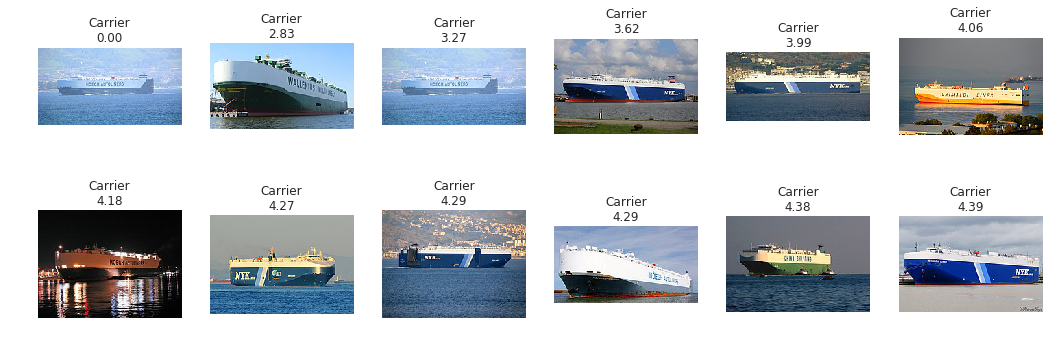

In [0]:
show_distances(data_container.train, new_image_index, indices[0].tolist(), distances[0].tolist(), cols=6)

## ***Inverse Image Search with Triplet SemiHard Loss***

In [0]:
triplet_inverse = ImageLearner(
    path=MODEL_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.5,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
triplet_inverse.load()

In [0]:
triplet_inverse.loss = tfa.losses.TripletSemiHardLoss()

In [0]:
triplet_inverse.model = keras.Model(
    inputs=triplet_inverse.base_model.input,
    outputs=keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(
        keras.layers.Dense(25, activation=None)(triplet_inverse.concat_layer)
    ),
)

In [0]:
triplet_inverse.model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
triplet_inverse.compile(optimizer=tf.keras.optimizers.Adam, lr=1e-4)

In [0]:
history = triplet_inverse.fit(
    train_dataset=data_container.train,
    validation_dataset=data_container.validation,
    epochs=3,
)

Train for 136 steps, validate for 17 steps
Epoch 1/3
136/136 [==============================] - 378s 3s/step - loss: 0.5105 - sparse_categorical_accuracy: 0.0221 - sparse_top_2_categorical_accuracy: 0.0545 - val_loss: 0.3675 - val_sparse_categorical_accuracy: 0.0184 - val_sparse_top_2_categorical_accuracy: 0.0423
Epoch 2/3
136/136 [==============================] - 346s 3s/step - loss: 0.2083 - sparse_categorical_accuracy: 0.0090 - sparse_top_2_categorical_accuracy: 0.0248 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.0037 - val_sparse_top_2_categorical_accuracy: 0.0092
Epoch 3/3
136/136 [==============================] - 339s 2s/step - loss: 0.0721 - sparse_categorical_accuracy: 0.0069 - sparse_top_2_categorical_accuracy: 0.0172 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.0074 - val_sparse_top_2_categorical_accuracy: 0.0165


In [0]:
image_embeddings = triplet_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x
)

In [0]:
neighbors = sk.neighbors.NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(image_embeddings)

In [0]:
new_image_index = np.random.randint(len(data_container.train))
new_image_index

3853

In [0]:
new_image_embeddings = triplet_inverse.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x[new_image_index : new_image_index + 1],
)

In [0]:
distances, indices = neighbors.kneighbors(new_image_embeddings, n_neighbors=11)

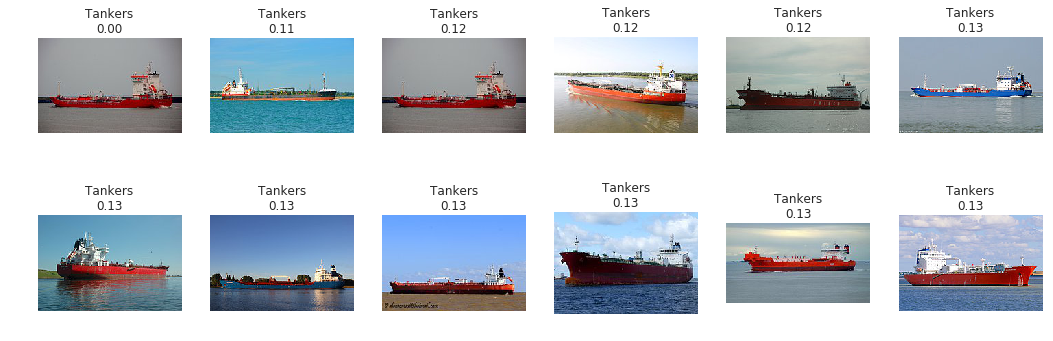

In [0]:
show_distances(data_container.train, new_image_index, indices[0].tolist(), distances[0].tolist(), cols=6)